# Wind Forecasting

## Prupose: predict the wind power within the next 48h
Wind Power Forecasting (WPF) represents how much wind power is to be expected in within a future time-frame. Accurate wind power forecasting can be used among other things to maximize the profit by electricity traders and it is a recognized as a major contribution for reliable large-scale wind power integration.


This paper seeks to use several deep neural network models in order predict the power of the wind across 7 wind farms within the next 48 hours (h). The performance of the models will be evaluated using the mean absolute error (MAE), mean squared error (MSE) and the root mean squared error (RMSE) between the prediction values and the actual observations. The experiments are carried out using the Kaggle dataset from the [Global Energy Forecasting Competition 2012](https://www.kaggle.com/c/GEF2012-wind-forecasting/)

More information about what was found can be found in the appended written article: Global Energy Wind Forecasting.pdf

In [1]:
'''
!pip install matplotlib==3.5.0
!pip install numpy==1.21.4
!pip install torch==1.10.1
!pip install pandas
'''

'\n!pip install matplotlib==3.5.0\n!pip install numpy==1.21.4\n!pip install torch==1.10.1\n!pip install pandas\n'

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear, GRU, Conv1d, Dropout, MaxPool1d, BatchNorm1d
from torch.utils.data import TensorDataset, DataLoader

#set a random seed
import random
seed_value = 12321
torch.manual_seed(seed_value)
np.random.seed(seed_value)

#set CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


### Data imported and processed form Kagle can be found at:
https://drive.google.com/drive/folders/1ZsC8JcLAQlhZGNaVrDMdVXLWh2X41ebF?usp=sharing 


In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
path = "drive/My Drive/DL_project/GEF2012-wind-forecasting/"
'''

In [5]:
path = 'Data/GEF2012-wind-forecasting/'

In [7]:
train_csv = pd.read_csv(path + 'train.csv')
test_csv = pd.read_csv(path + 'test.csv')

In [8]:
# Your code to produce answers here:
from IPython.display import display, HTML
print("TRAINING SET")
display(train_csv[:5])
print('No of samples: ',train_csv.shape)
print('Attributes are:\n ',train_csv.columns)

print("\nTEST SET")
display(test_csv[:5])
print('No of samples: ',test_csv.shape)
print('Attributes are:\n ',test_csv.columns)

TRAINING SET


,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
0,2009070100,0.045,0.233,0.494,0.105,0.056,0.118,0.051
1,2009070101,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2,2009070102,0.020,0.175,0.178,0.033,0.015,0.026,0.000
3,2009070103,0.060,0.085,0.109,0.022,0.010,0.013,0.000
4,2009070104,0.045,0.032,0.079,0.039,0.010,0.000,0.000


No of samples:  (18757, 8)
Attributes are:
  Index(['date', 'wp1', 'wp2', 'wp3', 'wp4', 'wp5', 'wp6', 'wp7'], dtype='object')

TEST SET


,id,date
0,4866,2011122106
1,2167,2011060719
2,5522,2012020714
3,6474,2012041518
4,3889,2011101113


No of samples:  (7488, 2)
Attributes are:
  Index(['id', 'date'], dtype='object')


In [ ]:
# convert the date into Timestamp object:
#training set
newdate_train = []
for i_date in range(len(train_csv.date)):
  datestr = str(train_csv['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_train.append(pd.to_datetime(date_form))

train_csv['Date'] = newdate_train
train_csv = train_csv.set_index('Date')


#test set
newdate_test = []
for i_date in range(len(test_csv.date)):
  datestr = str(test_csv['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_test.append(pd.to_datetime(date_form))

test_csv['Date'] = newdate_test
test_csv = test_csv.set_index('Date')

In [ ]:
# Add columns: year, month, and weekday
train_csv['Year'] = train_csv.index.year
train_csv['Month'] = train_csv.index.month
train_csv['day'] = train_csv.index.day
train_csv['hour'] = train_csv.index.hour

test_csv['Year'] = test_csv.index.year
test_csv['Month'] = test_csv.index.month
test_csv['day'] = test_csv.index.day
test_csv['hour'] = test_csv.index.hour

### Monthly evaluation

In [ ]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [ ]:
# convert the date into Timestamp object:
#training set
newdate_train = []
for i_date in range(len(train.date)):
  datestr = str(train['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_train.append(pd.to_datetime(date_form))

train['Date'] = newdate_train
train = train.set_index('Date')


#test set
newdate_test = []
for i_date in range(len(test_csv.date)):
  datestr = str(test['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_test.append(pd.to_datetime(date_form))

test['Date'] = newdate_test
test = test.set_index('Date')

Text(0, 0.5, 'Wind Power')

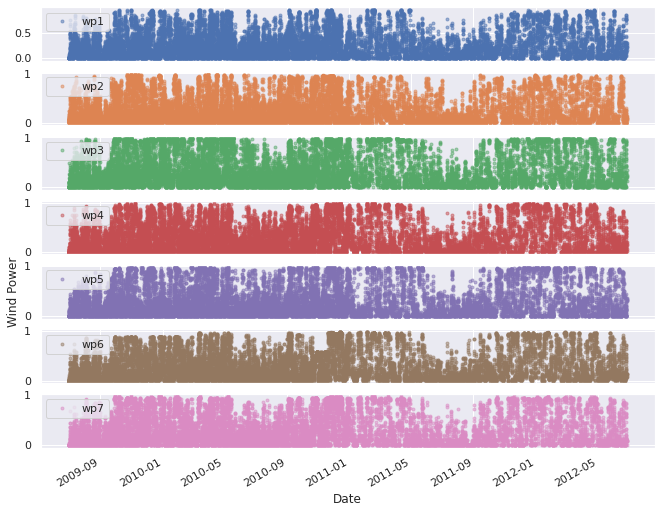

In [ ]:
cols_plot = train.columns[1:8]
axes = train[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[4].set_ylabel('Wind Power')

In [ ]:
# Specify the WP columns we want to include 
data_columns = train.columns[1:8]
# Resample to weekly frequency, aggregating with mean
train_weekly_mean = train[data_columns].resample('W').mean()
train_weekly_mean.head(3)

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
Date,,,,,,,
2009-07-05,0.136183,0.114283,0.099975,0.087567,0.109892,0.075983,0.055383
2009-07-12,0.195667,0.237923,0.152857,0.196298,0.103339,0.141560,0.121345
2009-07-19,0.219577,0.162464,0.212298,0.146702,0.183399,0.121494,0.107202


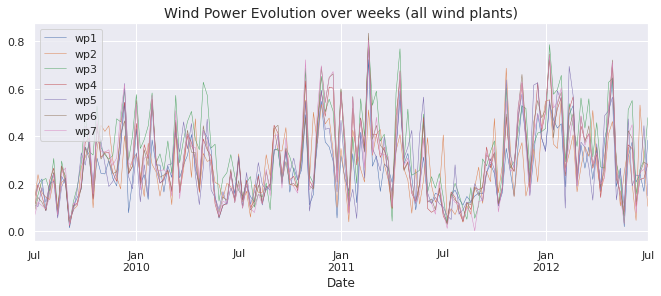

In [ ]:
#plotting evolution over time for all WPs
#Evolution of WPs over all values in time
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
for wp in train.columns[1:8]:
  train_weekly_mean[wp].plot(linewidth=0.5);
  plt.legend(loc='upper left')
  plt.title('Wind Power Evolution over weeks (all wind plants)', fontsize = 14)

In [ ]:
# Specify the WP columns we want to include 
data_columns = train.columns[1:8]
# Resample to monthly frequency, aggregating with mean
train_means_month = train[data_columns].resample('M').mean()
train_means_month.head(3)

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
Date,,,,,,,
2009-07-31,0.162945,0.154657,0.178030,0.137923,0.143727,0.111606,0.099379
2009-08-31,0.182888,0.185554,0.209464,0.207478,0.166766,0.206737,0.202368
2009-09-30,0.155025,0.161529,0.211086,0.160215,0.195524,0.157744,0.170704


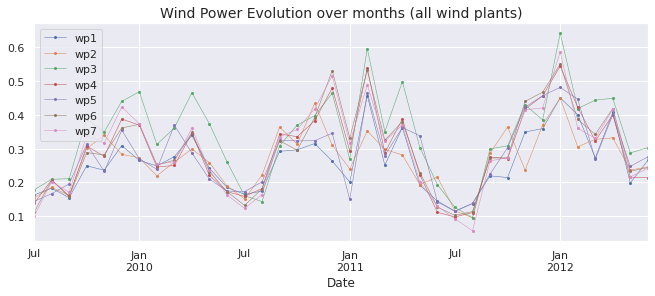

In [ ]:
#plotting evolution over time for all WPs
for wp in train.columns[1:8]:
  train_means_month[wp].plot(linewidth=0.5,marker='o', markersize=2, linestyle='-')
  plt.legend(loc='upper left')
  plt.title('Wind Power Evolution over months (all wind plants)', fontsize = 14)

In [ ]:
data_columns = train.columns[1:8]
train_monthly_sum = train[data_columns].resample('M').sum(min_count=28)
train_monthly_sum.head(3)

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
Date,,,,,,,
2009-07-31,121.231,115.065,132.454,102.615,106.933,83.035,73.938
2009-08-31,136.069,138.052,155.841,154.364,124.074,153.812,150.562
2009-09-30,111.618,116.301,151.982,115.355,140.777,113.576,122.907


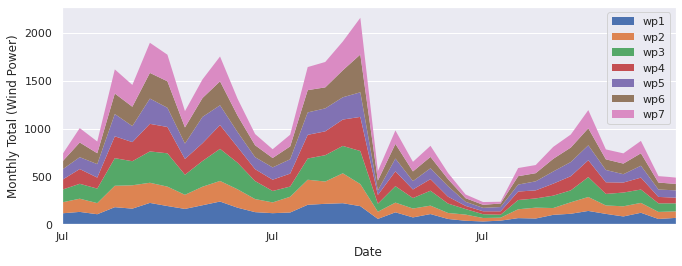

In [ ]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
#ax.plot(train_monthly_sum['wp1'], color='black', label='wp1')
train_monthly_sum[data_columns].plot.area(ax=ax, linewidth=0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (Wind Power)');

# WIND FARM 1 (WF1)

In [ ]:
train_wp1_unprocessed = train_csv.drop(columns=['date','wp2','wp3','wp4','wp5','wp6','wp7'])

In [ ]:
train_wp1_unprocessed['date'] = train_wp1_unprocessed.index.date
train_wp1_unprocessed = train_wp1_unprocessed.set_index('date')

## Add forecast attributes

Principle: make a table out of this


In [ ]:

w1_forecast = pd.read_csv(path + 'windforecasts_wf1.csv')

# convert the date into Timestamp object:
#training set
newdate_forecast = []
for i_date in range(len(w1_forecast.date)):
  datestr = str(w1_forecast['date'][i_date])
  date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
  newdate_forecast.append(pd.to_datetime(date_form))

w1_forecast['Date'] = newdate_forecast
w1_forecast = w1_forecast.set_index('Date')


In [ ]:
'''
w1_forecast['hour_forecast'] = w1_forecast.index.hour
w1_forecast['date'] = w1_forecast.index.date
w1_forecast['Number'] = [*range(len(w1_forecast))]
w1_forecast = w1_forecast.set_index('Number')
print(w1_forecast[:7])
'''

"\nw1_forecast['hour_forecast'] = w1_forecast.index.hour\nw1_forecast['date'] = w1_forecast.index.date\nw1_forecast['Number'] = [*range(len(w1_forecast))]\nw1_forecast = w1_forecast.set_index('Number')\nprint(w1_forecast[:7])\n"

In [ ]:
# append u,v,ws and wd based on closest timeframe forecastings
'''
import datetime

d = pd.DataFrame()
for i in range(len(train_wp1_unprocessed)):
  hour = int(train_wp1_unprocessed.iloc[i]['hour'])
  date = train_wp1_unprocessed.index[i]
  if hour == 0:
    date_forecast = date - datetime.timedelta(days=1)
    hour_forecast = 12
    hors = 13
    idx = (w1_forecast[(w1_forecast['date']  == date_forecast) & (w1_forecast['hour_forecast']  == hour_forecast) & (w1_forecast['hors'] == hors)]).index
    u = w1_forecast["u"].iloc[idx]
    v = w1_forecast["v"].iloc[idx]
    ws = w1_forecast["ws"].iloc[idx]
    wd = w1_forecast["wd"].iloc[idx]

  elif (1 <= hour) and (hour <= 12):
    date_forecast = date
    hour_forecast = 0
    hors = hour
    idx = (w1_forecast[(w1_forecast['date']  == date_forecast) & (w1_forecast['hour_forecast']  == hour_forecast) & (w1_forecast['hors'] == hors)]).index
    u = w1_forecast["u"].iloc[idx]
    v = w1_forecast["v"].iloc[idx]
    ws = w1_forecast["ws"].iloc[idx]
    wd = w1_forecast["wd"].iloc[idx]

  elif (13 <= hour) and (hour <= 23):
    date_forecast = date
    hour_forecast = 12
    hors = hour - 12
    idx = (w1_forecast[(w1_forecast['date']  == date_forecast) & (w1_forecast['hour_forecast']  == hour_forecast) & (w1_forecast['hors'] == hors)]).index
    u = w1_forecast["u"].iloc[idx]
    v = w1_forecast["v"].iloc[idx]
    ws = w1_forecast["ws"].iloc[idx]
    wd = w1_forecast["wd"].iloc[idx]

  temp = pd.DataFrame(
      {
          'u': u,
          'v': v,
          'ws': ws,
          'wd': wd,
          'date_forecast' : date_forecast,
          'hour_forecast' : hour_forecast,
          'hors' : hors
      }
  )

  d = pd.concat([d, temp])

d.to_csv(path + 'wp1_extracted_forecast_vals')
'''

'\nimport datetime\n\nd = pd.DataFrame()\nfor i in range(len(train_wp1_unprocessed)):\n  hour = int(train_wp1_unprocessed.iloc[i][\'hour\'])\n  date = train_wp1_unprocessed.index[i]\n  if hour == 0:\n    date_forecast = date - datetime.timedelta(days=1)\n    hour_forecast = 12\n    hors = 13\n    idx = (w1_forecast[(w1_forecast[\'date\']  == date_forecast) & (w1_forecast[\'hour_forecast\']  == hour_forecast) & (w1_forecast[\'hors\'] == hors)]).index\n    u = w1_forecast["u"].iloc[idx]\n    v = w1_forecast["v"].iloc[idx]\n    ws = w1_forecast["ws"].iloc[idx]\n    wd = w1_forecast["wd"].iloc[idx]\n\n  elif (1 <= hour) and (hour <= 12):\n    date_forecast = date\n    hour_forecast = 0\n    hors = hour\n    idx = (w1_forecast[(w1_forecast[\'date\']  == date_forecast) & (w1_forecast[\'hour_forecast\']  == hour_forecast) & (w1_forecast[\'hors\'] == hors)]).index\n    u = w1_forecast["u"].iloc[idx]\n    v = w1_forecast["v"].iloc[idx]\n    ws = w1_forecast["ws"].iloc[idx]\n    wd = w1_forecast

#### Aldready processed - only need to upload

In [ ]:
forecast_wp1_processed = pd.read_csv(path + 'wp1_extracted_forecast_vals')

In [ ]:
# drop first row as we do not have a forecast for it
train_wp1_unprocessed = train_wp1_unprocessed.tail(train_wp1_unprocessed.shape[0] -1)

In [ ]:
forecast_wp1_processed.reset_index(drop=True, inplace=True)
train_wp1_unprocessed.reset_index(drop=True, inplace=True)
train_wp1_unprocessed = pd.concat([forecast_wp1_processed, train_wp1_unprocessed], axis=1)

In [ ]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    #for n in range(1, n_lags + 1):
    #    df_n[f"lag_p{n}"] = df_n["wp1"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_u{n}"] = df_n["u"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_v{n}"] = df_n["v"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_ws{n}"] = df_n["ws"].shift(n)

    for n in range(1, n_lags + 1):
        df_n[f"lag_wd{n}"] = df_n["wd"].shift(n)

    df_n = df_n.iloc[n_lags:]
    df_n['hourr'] = ["{0:0=2d}".format(df_n['hour'].iloc[i]) for i in range(len(df_n))]
    cols=["Year","Month","day","hourr"]
    df_n['proper_date'] = df_n[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

    print(df_n['proper_date'].iloc[0])

    return df_n

In [ ]:
train_wp1_unprocessed

,Number,u,v,ws,wd,date_forecast,hour_forecast,hors,wp1,Year,Month,day,hour
0,0,2.34,-0.79,2.47,108.68,2009-07-01,0,1,0.085,2009,7,1,1
1,1,2.18,-0.99,2.40,114.31,2009-07-01,0,2,0.020,2009,7,1,2
2,2,2.20,-1.21,2.51,118.71,2009-07-01,0,3,0.060,2009,7,1,3
3,3,2.35,-1.40,2.73,120.86,2009-07-01,0,4,0.045,2009,7,1,4
4,4,2.53,-1.47,2.93,120.13,2009-07-01,0,5,0.035,2009,7,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,104743,1.77,-1.52,2.34,130.63,2012-06-26,0,8,0.170,2012,6,26,8
18752,104744,1.93,-1.52,2.46,128.25,2012-06-26,0,9,0.211,2012,6,26,9
18753,104745,2.10,-1.73,2.72,129.58,2012-06-26,0,10,0.251,2012,6,26,10
18754,104746,2.21,-2.19,3.11,134.64,2012-06-26,0,11,0.301,2012,6,26,11


In [ ]:
# generte timelags for wp1
input_dim = 100

train_wp1 = generate_time_lags(train_wp1_unprocessed, input_dim)


2009-7-5-05


In [ ]:
train_wp1['proper_date']

100       2009-7-5-05
101       2009-7-5-06
102       2009-7-5-07
103       2009-7-5-08
104       2009-7-5-09
             ...     
18751    2012-6-26-08
18752    2012-6-26-09
18753    2012-6-26-10
18754    2012-6-26-11
18755    2012-6-26-12
Name: proper_date, Length: 18656, dtype: object

In [ ]:
def create_obs_per_row(idx, columns, df):
  #pow_lag = []

  u_lag = []
  v_lag = []
  ws_lag = []
  wd_lag = []
  date_l = []
  for col in columns:
    #if 'lag_p' in col:
    #  pow_lag.append(df[col].iloc[idx])
    if 'lag_u' in col:
      u_lag.append(df[col].iloc[idx])
    elif 'lag_v' in col:
      v_lag.append(df[col].iloc[idx])
    elif 'lag_ws' in col:
      ws_lag.append(df[col].iloc[idx])
    elif 'lag_wd' in col:
      wd_lag.append(df[col].iloc[idx])
    elif 'proper_date' in col:
      date = df[col].iloc[idx]
      date_l = [date] * 100
  #return pow_lag, u_lag, v_lag, ws_lag, wd_lag
  return u_lag, v_lag, ws_lag, wd_lag, date_l

In [ ]:
X_list = []
Y_list = []
Date_list = []
 
for i in range(len(train_wp1)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wp1.columns, train_wp1)
  y_obs = train_wp1['wp1'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)

In [ ]:
print(len(X_list))
print(len(Y_list))
print(len(Date_list))

18656
18656
18656


In [ ]:
randomtestlist = random.sample(range(1, len(X_list)-100), 99)

## Splitting and Loading the Data

In [ ]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y, Date_list, ratio):
    X_test = []
    y_test = []
    date_test = []

    y_48h_last = y[-48:]
    X_48h_last = X[-48:]
    date_48h_last = Date_list[-48:]
    #print(len(date_48h_last))

    y = y[:-48]
    X = X[:-48]
    Date_list = Date_list[:-48]

    idx_to_delete = []
    for rand_idx in randomtestlist:
      y_48h = y[rand_idx:rand_idx+48]
      X_48h = X[rand_idx:rand_idx+48]
      date_48h = Date_list[rand_idx:rand_idx+48]
      #print(len(Date_list))
      #print(len(date_48h))

      X_test.extend(X_48h)
      y_test.extend(y_48h)
      date_test.extend(date_48h)

      del X[rand_idx:rand_idx+48]
      del y[rand_idx:rand_idx+48]
      del Date_list[rand_idx:rand_idx+48]

    X_test.extend(X_48h_last)
    y_test.extend(y_48h_last)
    date_test.extend(date_48h_last)
    val_ratio = 0.3

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test, date_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)

In [ ]:
# data scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
    

In [ ]:
scaler = get_scaler('minmax')

# scaling the data
for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print(y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))


(10001, 1)


In [ ]:
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

In [ ]:
# loading the data

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
len(train_features)

10001

# Modelling - 48h Prediction

# CNN

In [ ]:
import torch
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [ ]:
dropout_prob = 0.2


# <-- Input shape
height, width, channels = (X_train[0].shape[0], X_train[0].shape[1], 1)

# <-- No. Filters
num_filters_conv1 =  8 # <-- Filters in your convolutional layer
num_filters_conv2 = 8

# <-- Kernel size
kernel_size_conv1 = 4
kernel_size_conv2 = 4
kernel_size_pooling = 2

# <-- Padding
padding_conv1 = 2 
padding_conv2 = 2 
padding_pooling = 0

# <-- Stride
conv_stride_1 =  2      
conv_stride_2 = 2
pooling_stride = 2

# <-- Fully Connected Layer
n_hidden = 100

# Convolution helper functions 
def compute_conv_dim(dim_size, kernel_size, padding_conv, stride_conv):
    return int((dim_size - kernel_size + 2 * padding_conv) / stride_conv + 1)

def compute_pool_dim(dim_size, kernel_size, stride_conv):
    return int((dim_size - kernel_size ) / stride_conv + 1)

## Net class:    

class ConvNet(nn.Module):
    def __init__(self, n_hidden, output_dim, dropout_prob):
        super(ConvNet, self).__init__()

        # Conv. Layer 1        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=conv_stride_1,
                             padding=padding_conv1)
        
        self.height_conv1 = compute_conv_dim(height, kernel_size_conv1, padding_conv1, conv_stride_1)
        self.width_conv1 = compute_conv_dim(width, kernel_size_conv1, padding_conv1, conv_stride_1)

        # Addign an extra layer: does not improve much...
        #self.input_c1 = kernel_size_conv1*self.width_conv2*self.height_conv1
        '''
        # Conv. Layer 2
        self.conv_2 = nn.Conv2d(in_channels=num_filters_conv1,
                        out_channels=num_filters_conv2,
                        kernel_size=kernel_size_conv2,
                        stride=conv_stride_2,
                        padding=padding_conv2)
        
        self.height_conv2 = compute_conv_dim(self.height_conv1, kernel_size_conv2, padding_conv2, conv_stride_2)
        self.width_conv2 = compute_conv_dim(self.width_conv1, kernel_size_conv2, padding_conv2, conv_stride_2)
        '''
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=kernel_size_pooling, 
                          stride=pooling_stride)
        

        self.height_pool = compute_conv_dim(self.height_conv1, kernel_size_pooling, padding_pooling, pooling_stride)
        self.width_pool = compute_conv_dim(self.width_conv1, kernel_size_pooling, padding_pooling, pooling_stride)

        self.num_l1 = num_filters_conv2*self.height_pool * self.width_pool

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Hidden Layer

        self.hidden= Linear(in_features=self.num_l1,
                            out_features=n_hidden)
        #output:
        self.predict = Linear(in_features=n_hidden, 
                            out_features=output_dim)
         
        
    def forward(self, x):
       # input should be: [B,C,W,H]

        x = relu(self.conv_1(x))
        x = self.dropout(x)
        #print('Output, 1st layer of conv: ',x.shape)
        
        #x = relu(self.conv_2(x))
        #x = self.dropout(x)

        #print('Output, 2nd layer of conv: ',x.shape)
        x = self.pool(x)
        #print(x.shape)

        x = torch.flatten(x, 1)         # flatten all dimensions except batch    
        #print(x.shape)
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # output prediction
        return x


In [ ]:
# TESTING
#Test the forward pass with dummy data
x = np.random.normal(0,1, (5, 1, 4, 100)).astype('float32') #B,C,W,H

net = ConvNet(n_hidden = 50, output_dim = 48, dropout_prob= 0.2)

out = net(Variable(torch.from_numpy(x)))

print(out.shape)

torch.Size([5, 48])


# TRAINING
## Training using MAE as loss function 

In [ ]:
#@title Default title text
n_epochs = 50
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    # training step
    def train_step_cnn(self, x, y):
        y = y.to(device)
        # Sets model to train mode
        self.model.train()

        torch_x = torch.from_numpy(x).to(device)
        # Makes predictions
        yhat = self.model(Variable(torch_x))

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train_step_rnn(self, x, y):
        y = y.to(device)
        # Sets model to train mode
        self.model.train()

        x = x.to(device)
        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()


    #training
    def train(self, train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=1):
        #model_path = f'models/{self.model}_{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []

            # train set
            for x_batch, y_batch in train_loader:
                #reshape input according to the model used
                if self.model.__class__.__name__ == 'ConvNet':
                  x_batch = x_batch.view([batch_size, -1, n_features])

                  #print('x_batch shape: ',x_batch.shape)

                  x_batch = np.expand_dims(x_batch, axis=1)
                  y_batch = y_batch

                  loss = self.train_step_cnn(x_batch, y_batch)

                elif self.model.__class__.__name__ == 'LSTMNet':
                  x_batch = x_batch.view([batch_size, -1, n_features])
                  y_batch = y_batch

                  loss = self.train_step_rnn(x_batch, y_batch)

                loss = loss
                batch_losses.append(loss)
                
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            # validation set
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    
                    #reshape input according to the model used
                    if self.model.__class__.__name__ == 'ConvNet':
                      x_val = x_val.view([batch_size, -1, n_features])
                      x_val = np.expand_dims(x_val, axis=1)
                      
                      self.model.eval()
                      x_val = torch.from_numpy(x_val).to(device)
                      yhat = self.model(Variable(x_val))
                      
                    elif self.model.__class__.__name__ == 'LSTMNet':
                      x_val = x_val.view([batch_size, -1, n_features])
                      self.model.eval()

                      x_val = x_val.to(device)
                      yhat = self.model(x_val)
                    y_val = y_val.to(device)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)

                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        #torch.save(self.model.state_dict(), model_path)

    #evaluation of the test set
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                #reshape input according to the model used
                if self.model.__class__.__name__ == 'ConvNet':
                  x_test = x_test.view([batch_size, -1, n_features])
                  x_test = np.expand_dims(x_test, axis=1)
                  y_test = y_test.to(device)
                  self.model.eval()
                  x_test = torch.from_numpy(x_test).to(device)
                  yhat = self.model(Variable(x_test))

                elif self.model.__class__.__name__ == 'LSTMNet':
                  x_test = x_test.view([batch_size, -1, n_features])

                  x_test = x_test.to(device)
                  y_test = y_test.to(device)
                  self.model.eval()
                  #yhat = self.model(Variable(torch.from_numpy(x_test_wp)), Variable(torch.from_numpy(x_test_ws)), Variable(torch.from_numpy(x_test_wd)), Variable(torch.from_numpy(x_test_u)), Variable(torch.from_numpy(x_test_v)))
                  yhat = self.model(x_test)

                predictions.append(yhat.cpu().data.numpy())
                values.append(y_test.cpu().data.numpy())

        return predictions, values


    def plot_losses(self):
        train_losses = self.train_losses
        val_losses = self.val_losses

        plt.plot(train_losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")


        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

    

[1/50] Training loss: 14.2946	 Validation loss: 1.8570
[2/50] Training loss: 1.9917	 Validation loss: 0.8259
[3/50] Training loss: 1.0082	 Validation loss: 0.4982
[4/50] Training loss: 0.7131	 Validation loss: 0.6289
[5/50] Training loss: 0.4971	 Validation loss: 0.5210
[6/50] Training loss: 0.3864	 Validation loss: 0.2701
[7/50] Training loss: 0.3092	 Validation loss: 0.2159
[8/50] Training loss: 0.2444	 Validation loss: 0.1862
[9/50] Training loss: 0.2248	 Validation loss: 0.1811
[10/50] Training loss: 0.2242	 Validation loss: 0.2012
[20/50] Training loss: 0.0749	 Validation loss: 0.1065
[30/50] Training loss: 0.0472	 Validation loss: 0.0729
[40/50] Training loss: 0.0381	 Validation loss: 0.0562
[50/50] Training loss: 0.0335	 Validation loss: 0.0584


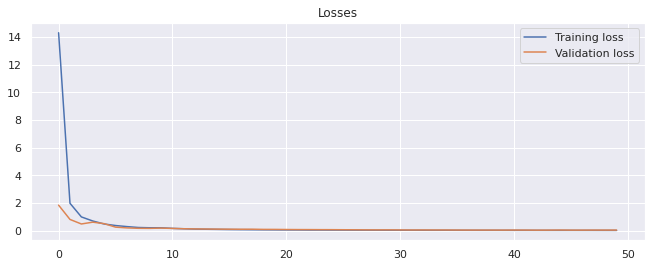

In [ ]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
learning_rate = 1e-3
weight_decay = 1e-6
batch_size = 64
n_epochs = 50


model = ConvNet(n_hidden = 50, output_dim = 1, dropout_prob= 0.2)
model = model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_cnn = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)


opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

# RNN - LSTM
- this time we have 5 series: power, ws, wd, u, v
- run each through an LSTM
- concatenate and run through a hidden layer (?)
- output

In [ ]:
no_features, input_dim = (X_train[0].shape[0], X_train[0].shape[1])

print(input_dim, no_features)

100 4


In [ ]:

#height, width, channels = IMAGE_SHAPE


# Keep track of features to output layer

hidden_size_lstm = 120
# <-- Input shape
no_features, input_dim = (X_train[0].shape[0], X_train[0].shape[1])

# [batch_size, sequence_length, input_dim]
# x_batch = x_batch.view([batch_size, -1, n_features])
# X[B, n_lag, forecast_features (4)]

    
class LSTMNet(nn.Module):
    def __init__(self, n_hidden, output_dim, n_hidden_fully_conntected, dropout_prob):
        super(LSTMNet, self).__init__()

        # Batch normalization - didn't use as it does not improve the kaggle score
        # self.fc1_bn=nn.BatchNorm2d(num_filters_conv2)

        # LSTM:

        self.lstm = nn.LSTM(input_size = int(input_dim), hidden_size = n_hidden, num_layers = 1, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Fully Connected Layer:
        self.hidden= Linear(in_features=n_hidden*no_features,
                    out_features=n_hidden_fully_conntected)
        # Output
        self.l_out = Linear(in_features= n_hidden_fully_conntected,
                            out_features=output_dim,
                            bias=False)
        
    def forward(self, x):
        #print('x before rnn ',x.shape)
        x, (_, _) = self.lstm(x)

        x = x.reshape(-1, self.lstm.hidden_size*no_features)

        #print(x.shape)
        x = F.relu(self.hidden(x))
        x = self.dropout(x)   
        out = self.l_out(x) 
        #print('output: ',out.shape)
        return out

net = LSTMNet(n_hidden = 100, output_dim =  48, n_hidden_fully_conntected= 500, dropout_prob = 0.2)

print(net)

LSTMNet(
  (lstm): LSTM(100, 100, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden): Linear(in_features=400, out_features=500, bias=True)
  (l_out): Linear(in_features=500, out_features=48, bias=False)
)


In [ ]:
# TESTING

# Size: [batch_size, no_features, input_dim]
x = torch.randn(64, 4, 100)

#lstm = nn.LSTM(input_size=int(input_dim), hidden_size=100, batch_first=True)

#output, _ = lstm(x)
#output.size()  

net = LSTMNet(n_hidden = 100, output_dim =  1, n_hidden_fully_conntected= 200, dropout_prob = 0.2)

out = net(x)
print(out.shape)

torch.Size([64, 1])


[1/50] Training loss: 0.0837	 Validation loss: 0.0809
[2/50] Training loss: 0.0634	 Validation loss: 0.0733
[3/50] Training loss: 0.0594	 Validation loss: 0.0705
[4/50] Training loss: 0.0561	 Validation loss: 0.0683
[5/50] Training loss: 0.0533	 Validation loss: 0.0664
[6/50] Training loss: 0.0510	 Validation loss: 0.0648
[7/50] Training loss: 0.0490	 Validation loss: 0.0632
[8/50] Training loss: 0.0474	 Validation loss: 0.0619
[9/50] Training loss: 0.0453	 Validation loss: 0.0607
[10/50] Training loss: 0.0443	 Validation loss: 0.0595
[20/50] Training loss: 0.0335	 Validation loss: 0.0527
[30/50] Training loss: 0.0281	 Validation loss: 0.0501
[40/50] Training loss: 0.0247	 Validation loss: 0.0490
[50/50] Training loss: 0.0218	 Validation loss: 0.0484


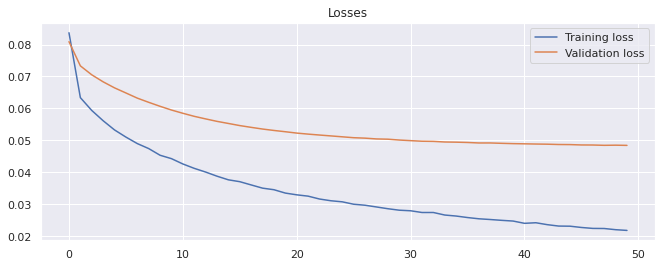

In [ ]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
learning_rate = 1e-5
weight_decay = 1e-10
batch_size = 64
n_epochs = 50


model = LSTMNet(n_hidden = 120, output_dim =  1, n_hidden_fully_conntected= 200, dropout_prob = 0.2)
model = model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_rnn = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()



# Evaluation

## LSTM with MSE loss

In [ ]:
predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, y_test, scaler):
    df_result = pd.DataFrame(data={"value": values, "prediction": predictions})
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    date_test_proper = [date_test[i][0] for i in range(len(date_test))]
    df_result['Date-str'] = date_test_proper
    df_result['Date'] = pd.to_datetime(df_result['Date-str'])
    return df_result

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn = format_predictions(preds , vals, y_test, scaler)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction, squared= False),
            'mse' : mean_squared_error(df.value, df.prediction)
            }

result_metrics = calculate_metrics(df_result_rnn)
print('Result metrics - LSTM with MSE (WF1): ', result_metrics)

Result metrics - LSTM with MSE (WF1):  {'mae': 0.14870939, 'rmse': 0.19275025, 'mse': 0.037152655}


## Baseline Model

In [ ]:
from sklearn.linear_model import LinearRegression

model_baseline = LinearRegression()

In [ ]:
def train_baseline_model(test_ratio, model, X_list, Y_list, date_test):
    X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
    X_train = np.array(X_train, dtype=np.float64)
    X_val = np.array(X_val, dtype=np.float64)
    X_test = np.array(X_test, dtype=np.float64 )
    y_train = np.array(y_train, dtype=np.float64)
    y_val = np.array(y_val, dtype=np.float64)
    y_test = np.array(y_test, dtype=np.float64)

    nsample , nx, ny = X_train.shape
    d2_X_train = X_train.reshape((nsample, nx*ny))
    #print(d2_X_train.shape)

    
    model.fit(d2_X_train, y_train)
    
    nsample , nx, ny = X_test.shape
    d2_X_test = X_test.reshape((nsample, nx*ny))
    prediction = model.predict(d2_X_test)

    result = pd.DataFrame(y_test)

    result["prediction"] = prediction
    result = result.sort_index()

    date_test_proper = []
    date_test_proper = [date_test[i][0] for i in range(len(date_test))]

    result['Date-str'] = date_test_proper

    result['Date'] = pd.to_datetime(result['Date-str'])
    

    return result

In [ ]:
def calculate_metrics_baseline(df):
    return {'mae' : mean_absolute_error(df[0], df.prediction),
            'rmse' : mean_squared_error(df[0], df.prediction) ** 0.5,
             'mse' : mean_squared_error(df[0], df.prediction)}

In [ ]:
training_session = 'WF1'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1 {'mae': 0.1291230918350514, 'rmse': 0.1701834243946561, 'mse': 0.02896239793869163}


In [ ]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def plot_predictions(df_result, df_baseline,title_str):
    data = []
    
    df_result.set_index(['Date'],inplace=True)
    df_baseline.set_index(['Date'],inplace=True)
    value = go.Scatter(
        x=df_result.index,
        y=df_result.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    baseline = go.Scatter(
        x=df_baseline.index,
        y=df_baseline.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='linear regression',
        marker=dict(),
        text=df_baseline.index,
        opacity=0.8,
    )
    data.append(baseline)
    
    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='predictions',
        marker=dict(),
        text=df_result.index,
        opacity=0.8,
    )
    data.append(prediction)
    
    layout = dict(
        title=title_str + " - Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Wind Power", ticklen=5, zeroline=False),
    )
    #xaxis = df_result['Date']

    fig = dict(data=data, layout=layout)
    iplot(fig)
    
%matplotlib inline    
# Set notebook mode to work in offline
#pyo.init_notebook_mode()

plot_predictions(df_result_rnn[-96:-48], df_baseline[-96:-48], 'LSTM with MSE loss (WF1)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1) - 48h window')

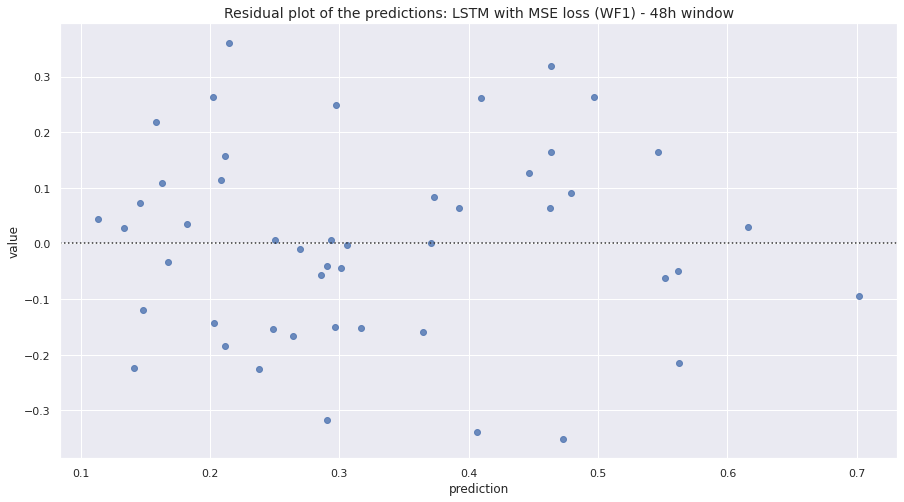

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn[-96:-48]['prediction'], y=df_result_rnn[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1) - 48h window', size=14)


## CNN with MSE loss

In [ ]:
# with CNN: 
predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn)
print('Result metrics for CNN with MSE loss (WF1): ', result_metrics)

Result metrics for CNN with MSE loss (WF1):  {'mae': 0.1882019, 'rmse': 0.22066262, 'mse': 0.048691995}


In [ ]:
plot_predictions(df_result_cnn[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1) - 48h window')

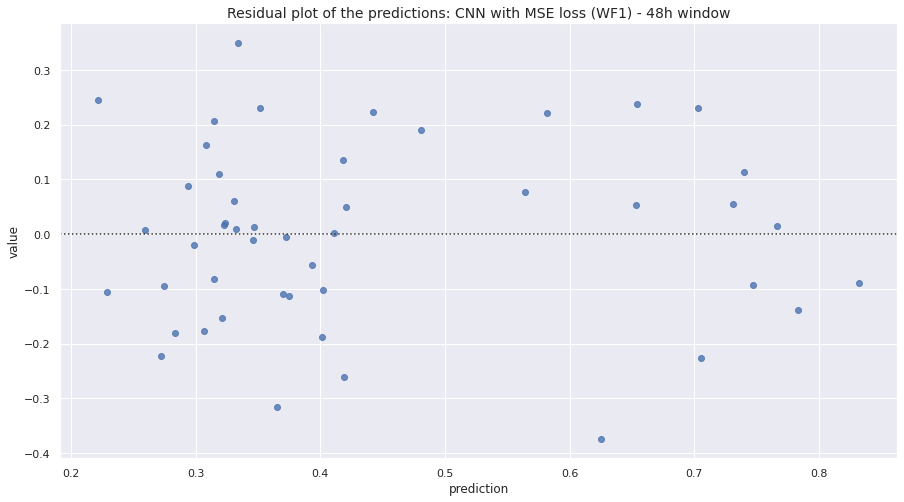

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn[-96:-48]['prediction'], y=df_result_cnn[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1) - 48h window', size=14)

# Training using MAE as loss function 

---



# CNN with MAE loss

[1/50] Training loss: 0.8063	 Validation loss: 0.3428
[2/50] Training loss: 0.2739	 Validation loss: 0.2612
[3/50] Training loss: 0.2152	 Validation loss: 0.2343
[4/50] Training loss: 0.1922	 Validation loss: 0.2074
[5/50] Training loss: 0.1742	 Validation loss: 0.1941
[6/50] Training loss: 0.1655	 Validation loss: 0.1863
[7/50] Training loss: 0.1561	 Validation loss: 0.1800
[8/50] Training loss: 0.1506	 Validation loss: 0.1795
[9/50] Training loss: 0.1444	 Validation loss: 0.1754
[10/50] Training loss: 0.1428	 Validation loss: 0.1759
[20/50] Training loss: 0.1287	 Validation loss: 0.1682
[30/50] Training loss: 0.1154	 Validation loss: 0.1747
[40/50] Training loss: 0.1078	 Validation loss: 0.1807
[50/50] Training loss: 0.1021	 Validation loss: 0.1751


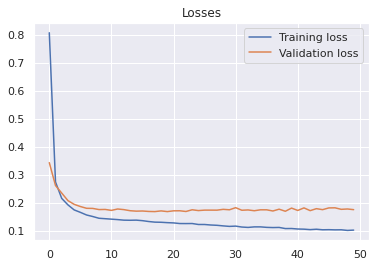

In [ ]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6
batch_size = 64
n_epochs = 50


model = ConvNet(n_hidden = 50, output_dim = 1, dropout_prob= 0.2)
model = model.to(device)


loss_fn = nn.L1Loss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_cnn_mae = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt_cnn_mae.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn_mae.plot_losses()

predictions, values = opt_cnn_mae.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

## Evaluation

In [ ]:
# with CNN: 
predictions, values = opt_cnn_mae.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_mae = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_mae)
print('Result metrics for CNN with MAE loss (WF1): ', result_metrics)

Result metrics for CNN with MAE loss (WF1):  {'mae': 0.15016796, 'rmse': 0.2020069, 'mse': 0.040806793}


In [ ]:
plot_predictions(df_result_cnn_mae[-96:-48], df_baseline[-96:-48], 'CNN with MAE loss (WF1)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MAE loss (WF1) - 48h window')

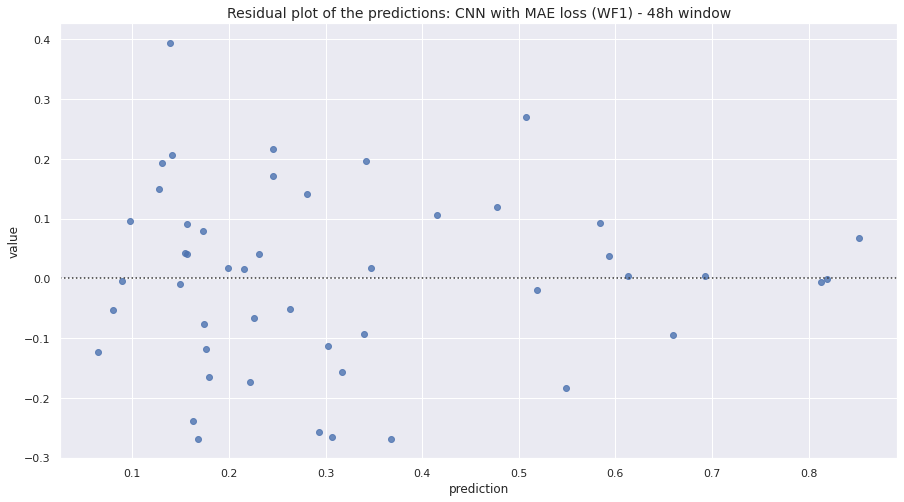

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_mae[-96:-48]['prediction'], y=df_result_cnn_mae[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MAE loss (WF1) - 48h window', size=14)

# LSTM with MAE loss

[1/50] Training loss: 0.2064	 Validation loss: 0.2214
[2/50] Training loss: 0.1892	 Validation loss: 0.2159
[3/50] Training loss: 0.1828	 Validation loss: 0.2123
[4/50] Training loss: 0.1779	 Validation loss: 0.2094
[5/50] Training loss: 0.1723	 Validation loss: 0.2066
[6/50] Training loss: 0.1698	 Validation loss: 0.2041
[7/50] Training loss: 0.1659	 Validation loss: 0.2019
[8/50] Training loss: 0.1633	 Validation loss: 0.1997
[9/50] Training loss: 0.1595	 Validation loss: 0.1978
[10/50] Training loss: 0.1572	 Validation loss: 0.1958
[20/50] Training loss: 0.1392	 Validation loss: 0.1832
[30/50] Training loss: 0.1264	 Validation loss: 0.1772
[40/50] Training loss: 0.1180	 Validation loss: 0.1741
[50/50] Training loss: 0.1110	 Validation loss: 0.1720


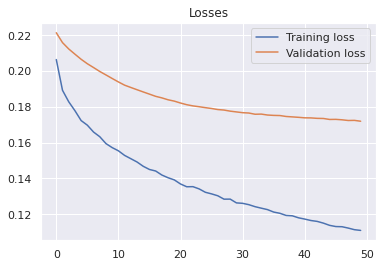

In [ ]:
import torch.optim as optim
import datetime

output_dim = 1
hidden_dim = 85
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-5
weight_decay = 1e-10
batch_size = 64
n_epochs = 50


model = LSTMNet(n_hidden = 120, output_dim =  1, n_hidden_fully_conntected= 200, dropout_prob = 0.2)
model = model.to(device)

loss_fn = nn.L1Loss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt_rnn_mae = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt_rnn_mae.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn_mae.plot_losses()

In [ ]:
# with RNN: 
predictions, values = opt_rnn_mae.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_mae = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_mae)
print('Result metrics for LSTM with MAE loss (WF1): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1):  {'mae': 0.1524985, 'rmse': 0.20104696, 'mse': 0.040419877}


In [ ]:
plot_predictions(df_result_rnn_mae[-96:-48], df_baseline[-96:-48],'LSTM with MAE loss')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MAE loss - 48h window')

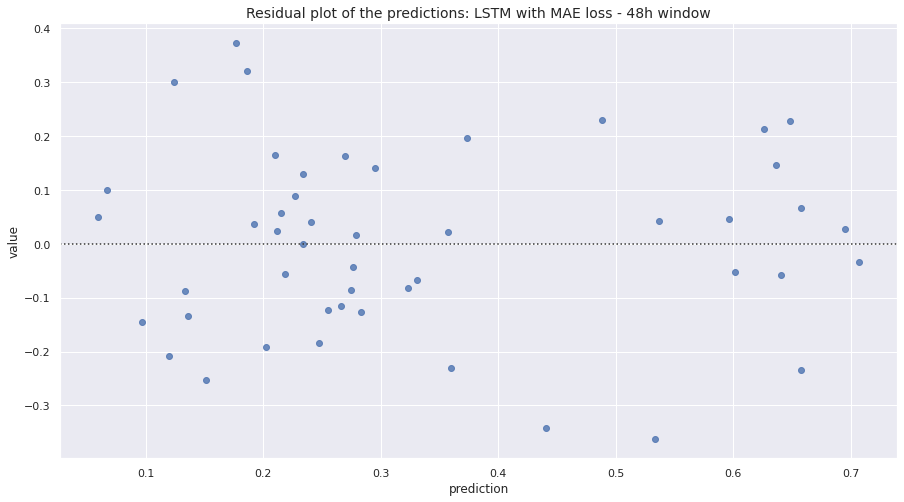

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_mae[-96:-48]['prediction'], y=df_result_rnn_mae[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MAE loss - 48h window', size=14)

# Model Training over several Wind Farms (WFs)

The models created above will be now trained on the data from the other 6 windfarms. Although the measurements from each wind farm are independent, we would like to test whether the model can improve and discover new patterns when fed with new data. 

### Generating the data-sets from the other windfarms: WP2, ..., WP7

The data will be generated as above and the model will be subsequentially trained on the datasets. 

In [ ]:
# function to process the data for each wind farm
def process_windfarm_data(w_forecast, train_wp_unprocessed):

  import datetime

  # convert the date into Timestamp object:
  #training set
  newdate_forecast = []
  for i_date in range(len(w_forecast.date)):
    datestr = str(w_forecast['date'][i_date])
    date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
    newdate_forecast.append(pd.to_datetime(date_form))

  w_forecast['Date'] = newdate_forecast
  w_forecast = w_forecast.set_index('Date')

  #indexing
  w_forecast['hour_forecast'] = w_forecast.index.hour
  w_forecast['date'] = w_forecast.index.date
  w_forecast['Number'] = [*range(len(w_forecast))]
  w_forecast = w_forecast.set_index('Number')

  # append u,v,ws and wd based on closest timeframe forecastings
  

  d = pd.DataFrame()
  for i in range(len(train_wp_unprocessed)):
    hour = int(train_wp_unprocessed.iloc[i]['hour'])
    date = train_wp_unprocessed.index[i]
    if hour == 0:
      date_forecast = date - datetime.timedelta(days=1)
      hour_forecast = 12
      hors = 13
      idx = (w_forecast[(w_forecast['date']  == date_forecast) & (w_forecast['hour_forecast']  == hour_forecast) & (w_forecast['hors'] == hors)]).index
      u = w_forecast["u"].iloc[idx]
      v = w_forecast["v"].iloc[idx]
      ws = w_forecast["ws"].iloc[idx]
      wd = w_forecast["wd"].iloc[idx]

    elif (1 <= hour) and (hour <= 12):
      date_forecast = date
      hour_forecast = 0
      hors = hour
      idx = (w_forecast[(w_forecast['date']  == date_forecast) & (w_forecast['hour_forecast']  == hour_forecast) & (w_forecast['hors'] == hors)]).index
      u = w_forecast["u"].iloc[idx]
      v = w_forecast["v"].iloc[idx]
      ws = w_forecast["ws"].iloc[idx]
      wd = w_forecast["wd"].iloc[idx]

    elif (13 <= hour) and (hour <= 23):
      date_forecast = date
      hour_forecast = 12
      hors = hour - 12
      idx = (w_forecast[(w_forecast['date']  == date_forecast) & (w_forecast['hour_forecast']  == hour_forecast) & (w_forecast['hors'] == hors)]).index
      u = w_forecast["u"].iloc[idx]
      v = w_forecast["v"].iloc[idx]
      ws = w_forecast["ws"].iloc[idx]
      wd = w_forecast["wd"].iloc[idx]

    temp = pd.DataFrame(
        {
            'u': u,
            'v': v,
            'ws': ws,
            'wd': wd,
            'date_forecast' : date_forecast,
            'hour_forecast' : hour_forecast,
            'hors' : hors
        }
    )

    d = pd.concat([d, temp])

  return d

## Preparing the data for the other wind farms 
(commented as it only needs to be done once)


In [ ]:

train_wp2_unprocessed = train_csv.drop(columns=['date','wp1','wp3','wp4','wp5','wp6','wp7'])
train_wp2_unprocessed['date'] = train_wp2_unprocessed.index.date
train_wp2_unprocessed = train_wp2_unprocessed.set_index('date')

'''
# Do only once and export - add forecast attributes
wf2_forecast = pd.read_csv(path + 'windforecasts_wf2.csv')

d = process_windfarm_data(wf2_forecast, train_wp2_unprocessed)

d.to_csv(path + 'wf2_extracted_forecast_vals')
'''

"\n# Do only once and export - add forecast attributes\nwf2_forecast = pd.read_csv(path + 'windforecasts_wf2.csv')\n\nd = process_windfarm_data(wf2_forecast, train_wp2_unprocessed)\n\nd.to_csv(path + 'wf2_extracted_forecast_vals')\n"

In [ ]:
train_wp3_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp4','wp5','wp6','wp7'])
train_wp3_unprocessed['date'] = train_wp3_unprocessed.index.date
train_wp3_unprocessed = train_wp3_unprocessed.set_index('date')

'''
# Do only once and export - add forecast attributes
wf3_forecast = pd.read_csv(path + 'windforecasts_wf3.csv')

d = process_windfarm_data(wf3_forecast, train_wp3_unprocessed)

d.to_csv(path + 'wf3_extracted_forecast_vals')
'''

"\n# Do only once and export - add forecast attributes\nwf3_forecast = pd.read_csv(path + 'windforecasts_wf3.csv')\n\nd = process_windfarm_data(wf3_forecast, train_wp3_unprocessed)\n\nd.to_csv(path + 'wf3_extracted_forecast_vals')\n"

In [ ]:

train_wp4_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp5','wp6','wp7'])
train_wp4_unprocessed['date'] = train_wp4_unprocessed.index.date
train_wp4_unprocessed = train_wp4_unprocessed.set_index('date')

'''
# Do only once and export - add forecast attributes
wf4_forecast = pd.read_csv(path + 'windforecasts_wf4.csv')

d = process_windfarm_data(wf4_forecast, train_wp4_unprocessed)

d.to_csv(path + 'wf4_extracted_forecast_vals')
'''

"\n# Do only once and export - add forecast attributes\nwf4_forecast = pd.read_csv(path + 'windforecasts_wf4.csv')\n\nd = process_windfarm_data(wf4_forecast, train_wp4_unprocessed)\n\nd.to_csv(path + 'wf4_extracted_forecast_vals')\n"

In [ ]:

train_wp5_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp4','wp6','wp7'])
train_wp5_unprocessed['date'] = train_wp5_unprocessed.index.date
train_wp5_unprocessed = train_wp5_unprocessed.set_index('date')

'''
# Do only once and export - add forecast attributes
wf5_forecast = pd.read_csv(path + 'windforecasts_wf5.csv')

d = process_windfarm_data(wf5_forecast, train_wp5_unprocessed)

d.to_csv(path + 'wf5_extracted_forecast_vals')
'''

"\n# Do only once and export - add forecast attributes\nwf5_forecast = pd.read_csv(path + 'windforecasts_wf5.csv')\n\nd = process_windfarm_data(wf5_forecast, train_wp5_unprocessed)\n\nd.to_csv(path + 'wf5_extracted_forecast_vals')\n"

In [ ]:

train_wp6_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp4','wp5','wp7'])
train_wp6_unprocessed['date'] = train_wp6_unprocessed.index.date
train_wp6_unprocessed = train_wp6_unprocessed.set_index('date')

'''
# Do only once and export - add forecast attributes
wf6_forecast = pd.read_csv(path + 'windforecasts_wf6.csv')

d = process_windfarm_data(wf6_forecast, train_wp6_unprocessed)

d.to_csv(path + 'wf6_extracted_forecast_vals')
'''

"\n# Do only once and export - add forecast attributes\nwf6_forecast = pd.read_csv(path + 'windforecasts_wf6.csv')\n\nd = process_windfarm_data(wf6_forecast, train_wp6_unprocessed)\n\nd.to_csv(path + 'wf6_extracted_forecast_vals')\n"

In [ ]:

train_wp7_unprocessed = train_csv.drop(columns=['date','wp1','wp2','wp3','wp4','wp5','wp6'])
train_wp7_unprocessed['date'] = train_wp7_unprocessed.index.date
train_wp7_unprocessed = train_wp7_unprocessed.set_index('date')

'''
# Do only once and export - add forecast attributes
wf7_forecast = pd.read_csv(path + 'windforecasts_wf7.csv')

d = process_windfarm_data(wf7_forecast, train_wp7_unprocessed)

d.to_csv(path + 'wf7_extracted_forecast_vals')
'''

"\n# Do only once and export - add forecast attributes\nwf7_forecast = pd.read_csv(path + 'windforecasts_wf7.csv')\n\nd = process_windfarm_data(wf7_forecast, train_wp7_unprocessed)\n\nd.to_csv(path + 'wf7_extracted_forecast_vals')\n"

# Further training of the best model (CNN with MSE loss)
- training it with more data from the other wind farms

# + WF2

In [ ]:
forecast_wf2_processed = pd.read_csv(path + 'wf2_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp2_unprocessed = train_wp2_unprocessed.tail(train_wp2_unprocessed.shape[0] -1)

forecast_wf2_processed.reset_index(drop=True, inplace=True)
train_wp2_unprocessed.reset_index(drop=True, inplace=True)
train_wf2_processed = pd.concat([forecast_wf2_processed, train_wp2_unprocessed], axis=1)

# generte timelags for WF2
input_dim = 100

train_wf2 = generate_time_lags(train_wf2_processed, input_dim)

train_wf2

2009-7-5-05


,Number,u,v,ws,wd,date_forecast,hour_forecast,hors,wp2,Year,Month,day,hour,lag_u1,lag_u2,lag_u3,lag_u4,lag_u5,lag_u6,lag_u7,lag_u8,lag_u9,lag_u10,lag_u11,lag_u12,lag_u13,lag_u14,lag_u15,lag_u16,lag_u17,lag_u18,lag_u19,lag_u20,lag_u21,lag_u22,lag_u23,lag_u24,lag_u25,lag_u26,lag_u27,...,lag_wd63,lag_wd64,lag_wd65,lag_wd66,lag_wd67,lag_wd68,lag_wd69,lag_wd70,lag_wd71,lag_wd72,lag_wd73,lag_wd74,lag_wd75,lag_wd76,lag_wd77,lag_wd78,lag_wd79,lag_wd80,lag_wd81,lag_wd82,lag_wd83,lag_wd84,lag_wd85,lag_wd86,lag_wd87,lag_wd88,lag_wd89,lag_wd90,lag_wd91,lag_wd92,lag_wd93,lag_wd94,lag_wd95,lag_wd96,lag_wd97,lag_wd98,lag_wd99,lag_wd100,hourr,proper_date
100,388,0.83,-0.43,0.93,117.60,2009-07-05,0,5,0.021,2009,7,5,5,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,1.58,1.83,2.23,...,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,124.85,121.76,120.20,05,2009-7-5-05
101,389,0.42,0.04,0.42,84.74,2009-07-05,0,6,0.032,2009,7,5,6,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,1.58,1.83,...,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,124.85,121.76,06,2009-7-5-06
102,390,0.66,1.10,1.28,30.95,2009-07-05,0,7,0.037,2009,7,5,7,0.42,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,1.58,...,131.05,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,124.85,07,2009-7-5-07
103,391,1.32,2.30,2.65,29.98,2009-07-05,0,8,0.058,2009,7,5,8,0.66,0.42,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,1.44,...,129.51,131.05,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,129.09,08,2009-7-5-08
104,392,2.11,3.04,3.70,34.69,2009-07-05,0,9,0.122,2009,7,5,9,1.32,0.66,0.42,0.83,1.63,2.47,3.03,3.06,2.20,2.86,3.45,3.98,4.32,4.44,4.36,4.11,3.72,3.23,2.67,2.08,1.85,1.56,1.40,1.33,1.31,1.32,1.36,...,128.36,129.51,131.05,132.82,134.43,135.01,121.73,115.14,103.99,98.11,101.54,107.46,111.14,111.52,110.50,109.87,110.98,114.46,113.65,126.58,130.24,131.60,131.16,130.13,129.85,131.45,134.24,136.66,136.65,131.99,131.00,127.29,123.11,121.38,124.72,130.46,134.05,132.96,09,2009-7-5-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,104743,1.99,-1.37,2.42,124.49,2012-06-26,0,8,0.138,2012,6,26,8,2.09,2.14,2.10,2.07,2.11,2.32,2.77,3.20,4.11,4.36,4.62,4.97,5.26,5.30,4.94,4.28,3.44,2.56,1.71,1.01,0.36,-0.21,-0.72,-1.13,-1.37,-1.30,-0.85,...,132.73,126.96,121.92,120.57,125.93,20.25,20.05,30.76,42.87,46.25,43.15,35.01,19.40,357.84,337.88,325.60,323.43,340.85,324.77,330.08,337.42,342.13,343.39,341.56,336.79,330.01,322.66,316.57,313.40,318.39,317.71,320.59,326.93,335.19,344.35,354.51,5.85,15.96,08,2012-6-26-08
18752,104744,1.87,-1.40,2.34,126.69,2012-06-26,0,9,0.106,2012,6,26,9,1.99,2.09,2.14,2.10,2.07,2.11,2.32,2.77,3.20,4.11,4.36,4.62,4.97,5.26

In [ ]:
train_wf2_processed

,Number,u,v,ws,wd,date_forecast,hour_forecast,hors,wp2,Year,Month,day,hour
0,0,3.32,-1.93,3.84,120.20,2009-07-01,0,1,0.249,2009,7,1,1
1,1,2.88,-1.78,3.39,121.76,2009-07-01,0,2,0.175,2009,7,1,2
2,2,2.46,-1.71,2.99,124.85,2009-07-01,0,3,0.085,2009,7,1,3
3,3,2.07,-1.68,2.67,129.09,2009-07-01,0,4,0.032,2009,7,1,4
4,4,1.77,-1.65,2.42,132.96,2009-07-01,0,5,0.011,2009,7,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,104743,1.99,-1.37,2.42,124.49,2012-06-26,0,8,0.138,2012,6,26,8
18752,104744,1.87,-1.40,2.34,126.69,2012-06-26,0,9,0.106,2012,6,26,9
18753,104745,1.78,-1.40,2.26,128.19,2012-06-26,0,10,0.090,2012,6,26,10
18754,104746,1.76,-1.40,2.25,128.54,2012-06-26,0,11,0.058,2012,6,26,11


### Preparing the inpout data (X and Y)

In [ ]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf2)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf2.columns, train_wf2)
  y_obs = train_wf2['wp2'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))


Len of X 18656
Len of Y 18656
Target shape:  (10001, 1)
Training features 10001


In [ ]:
# train baseline model
training_session = 'WF1+WF2'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2 {'mae': 0.14070949562937668, 'rmse': 0.1839503238957524, 'mse': 0.03383772166135221}


### CNN with MSE

[1/50] Training loss: 0.0512	 Validation loss: 0.0806
[2/50] Training loss: 0.0458	 Validation loss: 0.0797
[3/50] Training loss: 0.0468	 Validation loss: 0.0818
[4/50] Training loss: 0.0434	 Validation loss: 0.0743
[5/50] Training loss: 0.0410	 Validation loss: 0.0684
[6/50] Training loss: 0.0405	 Validation loss: 0.0660
[7/50] Training loss: 0.0381	 Validation loss: 0.0652
[8/50] Training loss: 0.0386	 Validation loss: 0.0700
[9/50] Training loss: 0.0378	 Validation loss: 0.0620
[10/50] Training loss: 0.0361	 Validation loss: 0.0604
[20/50] Training loss: 0.0287	 Validation loss: 0.0495
[30/50] Training loss: 0.0233	 Validation loss: 0.0502
[40/50] Training loss: 0.0195	 Validation loss: 0.0515
[50/50] Training loss: 0.0212	 Validation loss: 0.0528


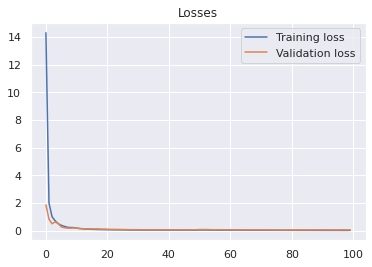

In [ ]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)


## Result Metrics after WF1+WF2 training



In [ ]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf2 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf2)
print('Result metrics for CNN with MAE loss (WF1+WF2): ', result_metrics)

Result metrics for CNN with MAE loss (WF1+WF2):  {'mae': 0.1649622, 'rmse': 0.20947906, 'mse': 0.043881476}


In [ ]:
#Plotting predictions
plot_predictions(df_result_cnn_wf2[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1+WF2)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2) - 48h window')

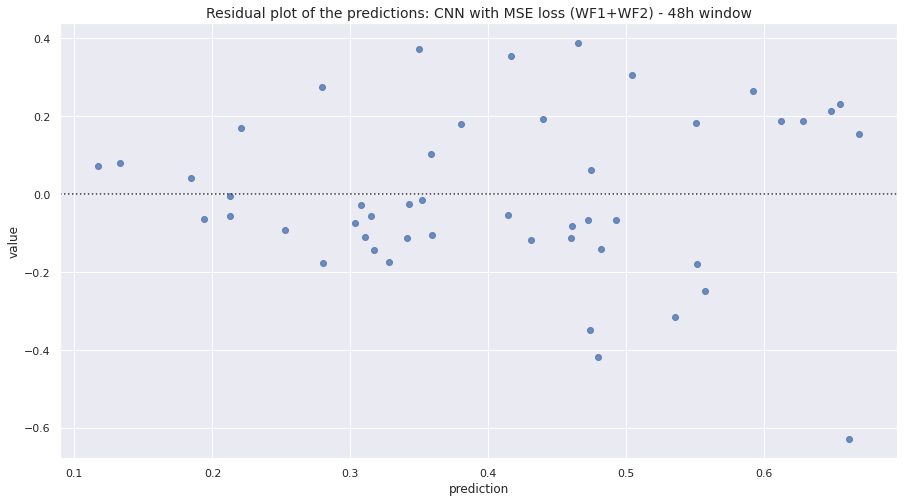

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf2[-96:-48]['prediction'], y=df_result_cnn_wf2[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0435	 Validation loss: 0.0506
[2/50] Training loss: 0.0399	 Validation loss: 0.0495
[3/50] Training loss: 0.0379	 Validation loss: 0.0489
[4/50] Training loss: 0.0364	 Validation loss: 0.0485
[5/50] Training loss: 0.0349	 Validation loss: 0.0482
[6/50] Training loss: 0.0343	 Validation loss: 0.0478
[7/50] Training loss: 0.0331	 Validation loss: 0.0477
[8/50] Training loss: 0.0325	 Validation loss: 0.0475
[9/50] Training loss: 0.0316	 Validation loss: 0.0473
[10/50] Training loss: 0.0309	 Validation loss: 0.0472
[20/50] Training loss: 0.0261	 Validation loss: 0.0464
[30/50] Training loss: 0.0230	 Validation loss: 0.0462
[40/50] Training loss: 0.0205	 Validation loss: 0.0463
[50/50] Training loss: 0.0184	 Validation loss: 0.0465


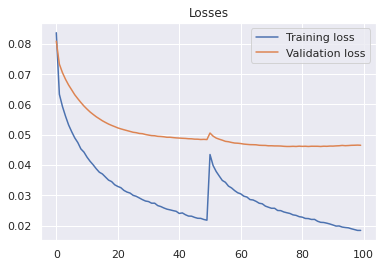

In [ ]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf2 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf2)
print('Result metrics for LSTM with MAE loss (WF1+WF2): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1+WF2):  {'mae': 0.15275216, 'rmse': 0.20036125, 'mse': 0.04014463}


In [ ]:
#Plotting predictions
plot_predictions(df_result_rnn_wf2[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1+WF2)')

plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2) - 48h window')

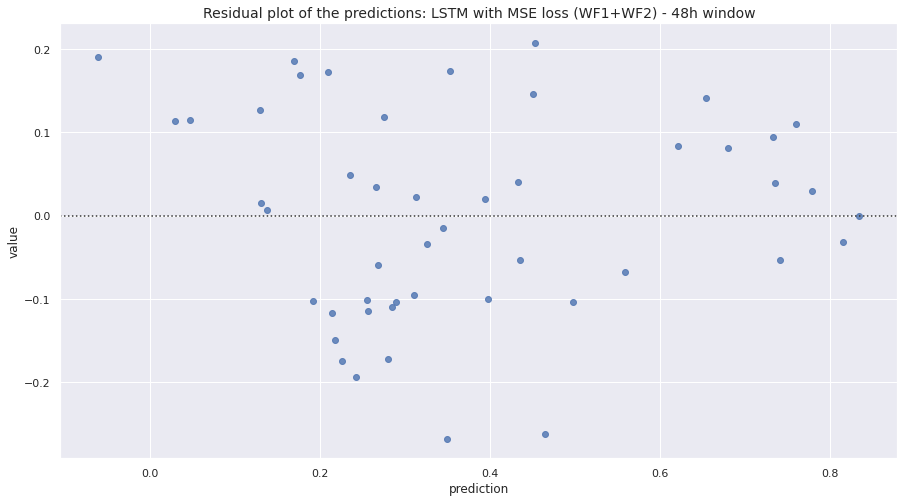

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf2[-96:-48]['prediction'], y=df_result_rnn_wf2[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2) - 48h window',size=14)

# + WF5
- since it has a similar seasonality

In [ ]:
forecast_wf5_processed = pd.read_csv(path + 'wf5_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp5_unprocessed = train_wp5_unprocessed.tail(train_wp5_unprocessed.shape[0] -1)

forecast_wf5_processed.reset_index(drop=True, inplace=True)
train_wp5_unprocessed.reset_index(drop=True, inplace=True)
train_wf5_processed = pd.concat([forecast_wf5_processed, train_wp5_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf5 = generate_time_lags(train_wf5_processed, input_dim)

2009-7-5-05


In [ ]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf5)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf5.columns, train_wf5)
  y_obs = train_wf5['wp5'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10001, 1)
Training features 10001


In [ ]:
# train baseline model
training_session = 'WF1+WF2+WF5'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5 {'mae': 0.13511661597143576, 'rmse': 0.17913798770468062, 'mse': 0.032090418638882304}


[1/50] Training loss: 0.0476	 Validation loss: 0.0574
[2/50] Training loss: 0.0397	 Validation loss: 0.0541
[3/50] Training loss: 0.0367	 Validation loss: 0.0514
[4/50] Training loss: 0.0369	 Validation loss: 0.0516
[5/50] Training loss: 0.0351	 Validation loss: 0.0519
[6/50] Training loss: 0.0350	 Validation loss: 0.0509
[7/50] Training loss: 0.0333	 Validation loss: 0.0509
[8/50] Training loss: 0.0323	 Validation loss: 0.0498
[9/50] Training loss: 0.0320	 Validation loss: 0.0504
[10/50] Training loss: 0.0310	 Validation loss: 0.0522
[20/50] Training loss: 0.0233	 Validation loss: 0.0540
[30/50] Training loss: 0.0225	 Validation loss: 0.0578
[40/50] Training loss: 0.0209	 Validation loss: 0.0675
[50/50] Training loss: 0.0180	 Validation loss: 0.0609


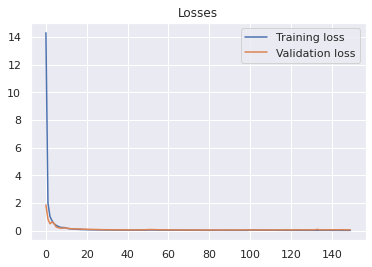

In [ ]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

## Result Metrics after WF1+WF2+WF5 training

In [ ]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf5 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf5)
print('Result metrics for CNN with MSE loss (WF1+WF2+WF5): ', result_metrics)

Result metrics for CNN with MSE loss (WF1+WF2+WF5):  {'mae': 0.15862703, 'rmse': 0.20810482, 'mse': 0.043307614}


In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf5[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1 + WF2 + WF5)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5) - 48h window')

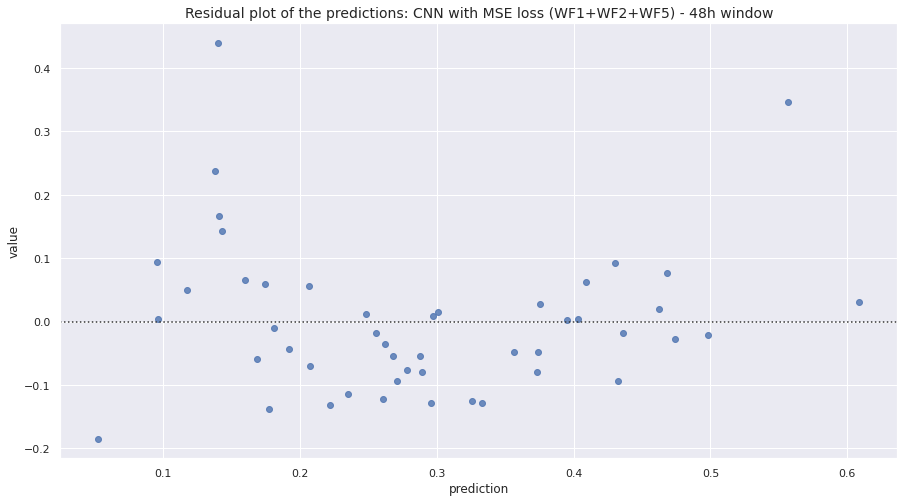

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf5[-96:-48]['prediction'], y=df_result_cnn_wf5[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0422	 Validation loss: 0.0609
[2/50] Training loss: 0.0383	 Validation loss: 0.0594
[3/50] Training loss: 0.0359	 Validation loss: 0.0581
[4/50] Training loss: 0.0347	 Validation loss: 0.0575
[5/50] Training loss: 0.0334	 Validation loss: 0.0572
[6/50] Training loss: 0.0324	 Validation loss: 0.0566
[7/50] Training loss: 0.0314	 Validation loss: 0.0563
[8/50] Training loss: 0.0309	 Validation loss: 0.0560
[9/50] Training loss: 0.0302	 Validation loss: 0.0556
[10/50] Training loss: 0.0298	 Validation loss: 0.0553
[20/50] Training loss: 0.0257	 Validation loss: 0.0535
[30/50] Training loss: 0.0231	 Validation loss: 0.0527
[40/50] Training loss: 0.0208	 Validation loss: 0.0522
[50/50] Training loss: 0.0190	 Validation loss: 0.0519


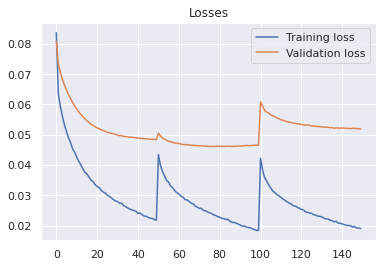

In [ ]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf5 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf5)
print('Result metrics for LSTM with MSE loss (WF1+WF2+WF5): ', result_metrics)

Result metrics for LSTM with MSE loss (WF1+WF2+WF5):  {'mae': 0.14939135, 'rmse': 0.19785455, 'mse': 0.039146423}


In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf5[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1 + WF2 + WF5)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5) - 48h window')

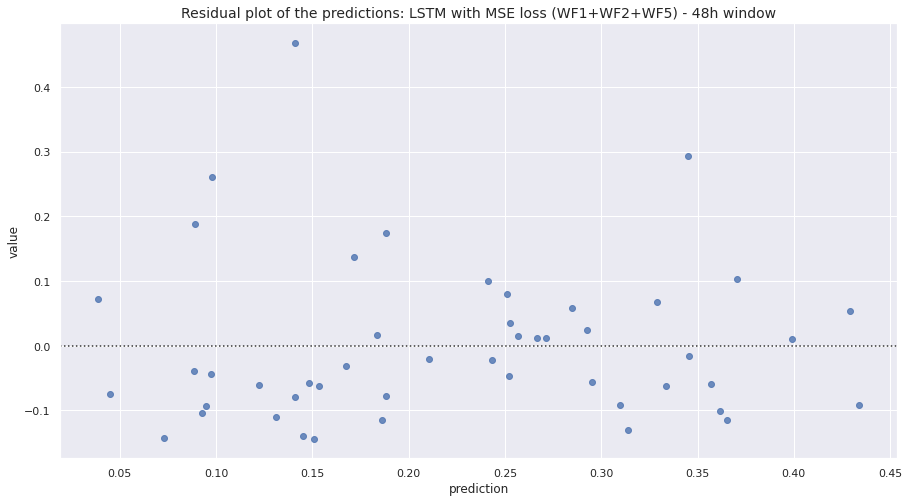

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf5[-96:-48]['prediction'], y=df_result_rnn_wf5[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5) - 48h window',size=14)

# + WF6

In [ ]:
forecast_wf6_processed = pd.read_csv(path + 'wf6_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp6_unprocessed = train_wp6_unprocessed.tail(train_wp6_unprocessed.shape[0] -1)

forecast_wf6_processed.reset_index(drop=True, inplace=True)
train_wp6_unprocessed.reset_index(drop=True, inplace=True)
train_wf6_processed = pd.concat([forecast_wf6_processed, train_wp6_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf6 = generate_time_lags(train_wf6_processed, input_dim)

2009-7-5-05


In [ ]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf6)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf6.columns, train_wf6)
  y_obs = train_wf6['wp6'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10001, 1)
Training features 10001


In [ ]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5+WF6 {'mae': 0.12654480961305672, 'rmse': 0.17052442049473202, 'mse': 0.029078577985064177}


[1/50] Training loss: 0.0379	 Validation loss: 0.0490
[2/50] Training loss: 0.0321	 Validation loss: 0.0458
[3/50] Training loss: 0.0285	 Validation loss: 0.0503
[4/50] Training loss: 0.0279	 Validation loss: 0.0453
[5/50] Training loss: 0.0257	 Validation loss: 0.0446
[6/50] Training loss: 0.0249	 Validation loss: 0.0473
[7/50] Training loss: 0.0239	 Validation loss: 0.0438
[8/50] Training loss: 0.0246	 Validation loss: 0.0462
[9/50] Training loss: 0.0231	 Validation loss: 0.0438
[10/50] Training loss: 0.0229	 Validation loss: 0.0460
[20/50] Training loss: 0.0167	 Validation loss: 0.0498
[30/50] Training loss: 0.0139	 Validation loss: 0.0543
[40/50] Training loss: 0.0130	 Validation loss: 0.0544
[50/50] Training loss: 0.0117	 Validation loss: 0.0541


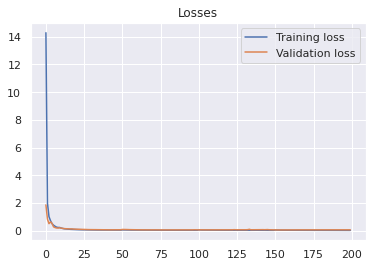

In [ ]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)


In [ ]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf6 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf6)
print('Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6): ', result_metrics)

Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6):  {'mae': 0.14345883, 'rmse': 0.19173267, 'mse': 0.036761418}


In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf6[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1 + WF2 + WF5 + WF6)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6) - 48h window')

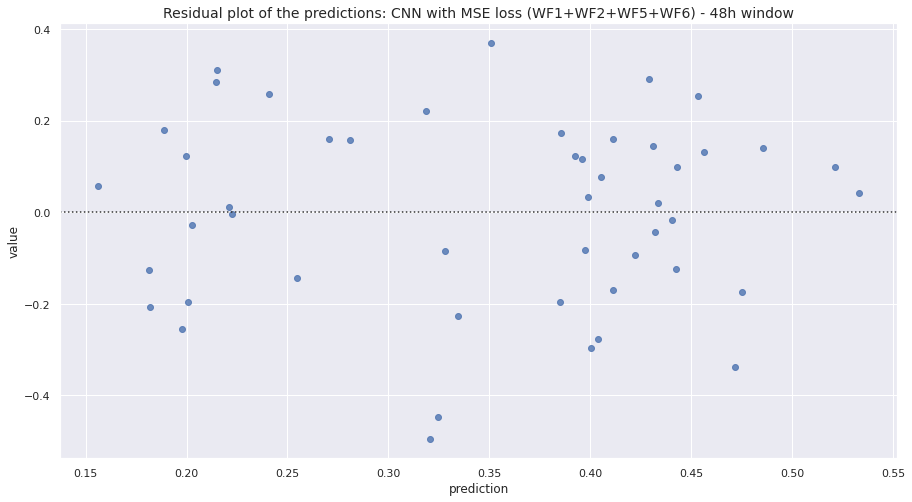

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf6[-96:-48]['prediction'], y=df_result_cnn_wf6[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0303	 Validation loss: 0.0475
[2/50] Training loss: 0.0266	 Validation loss: 0.0478
[3/50] Training loss: 0.0251	 Validation loss: 0.0476
[4/50] Training loss: 0.0239	 Validation loss: 0.0478
[5/50] Training loss: 0.0228	 Validation loss: 0.0480
[6/50] Training loss: 0.0222	 Validation loss: 0.0477
[7/50] Training loss: 0.0216	 Validation loss: 0.0477
[8/50] Training loss: 0.0211	 Validation loss: 0.0477
[9/50] Training loss: 0.0207	 Validation loss: 0.0475
[10/50] Training loss: 0.0203	 Validation loss: 0.0476
[20/50] Training loss: 0.0171	 Validation loss: 0.0475
[30/50] Training loss: 0.0150	 Validation loss: 0.0479
[40/50] Training loss: 0.0134	 Validation loss: 0.0486
[50/50] Training loss: 0.0117	 Validation loss: 0.0490


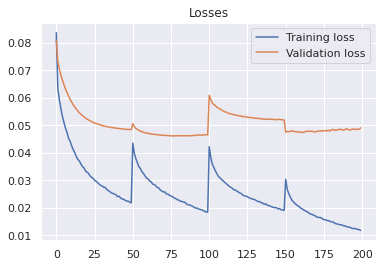

In [ ]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf6 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf6)
print('Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6): ', result_metrics)

Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6):  {'mae': 0.13681622, 'rmse': 0.1859515, 'mse': 0.03457796}


In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf6[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1 + WF2 + WF5 + WF6)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6) - 48h window')

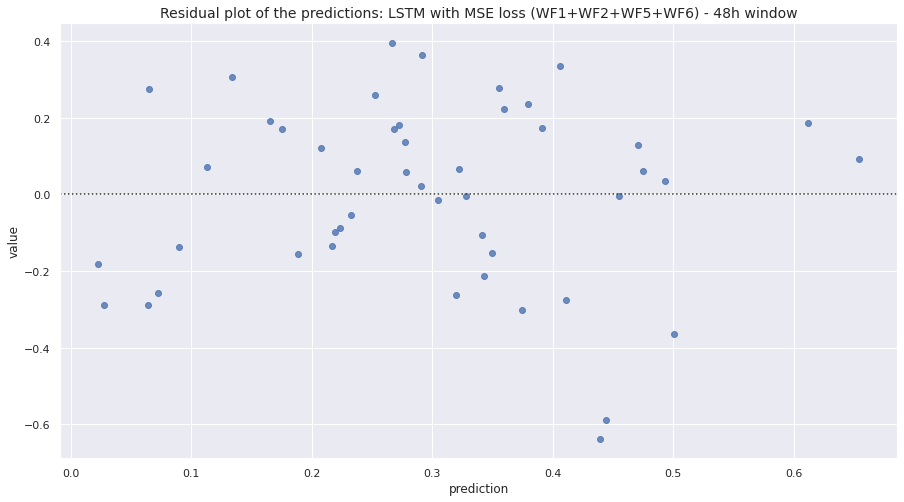

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf6[-96:-48]['prediction'], y=df_result_rnn_wf6[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6) - 48h window',size=14)

# + WF7

In [ ]:
forecast_wf7_processed = pd.read_csv(path + 'wf7_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp7_unprocessed = train_wp7_unprocessed.tail(train_wp7_unprocessed.shape[0] -1)

forecast_wf7_processed.reset_index(drop=True, inplace=True)
train_wp7_unprocessed.reset_index(drop=True, inplace=True)
train_wf7_processed = pd.concat([forecast_wf7_processed, train_wp7_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf7 = generate_time_lags(train_wf7_processed, input_dim)

2009-7-5-05


In [ ]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf7)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf7.columns, train_wf7)
  y_obs = train_wf7['wp7'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10001, 1)
Training features 10001


In [ ]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6+WF7'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

Baseline Linear Regression result metrics for WF1+WF2+WF5+WF6+WF7 {'mae': 0.125712310162482, 'rmse': 0.16416662986571928, 'mse': 0.02695068236146807}


[1/50] Training loss: 0.0262	 Validation loss: 0.0806
[2/50] Training loss: 0.0250	 Validation loss: 0.0877
[3/50] Training loss: 0.0238	 Validation loss: 0.0665
[4/50] Training loss: 0.0194	 Validation loss: 0.0800
[5/50] Training loss: 0.0199	 Validation loss: 0.0693
[6/50] Training loss: 0.0175	 Validation loss: 0.0692
[7/50] Training loss: 0.0170	 Validation loss: 0.0701
[8/50] Training loss: 0.0170	 Validation loss: 0.0720
[9/50] Training loss: 0.0169	 Validation loss: 0.0673
[10/50] Training loss: 0.0167	 Validation loss: 0.0658
[20/50] Training loss: 0.0139	 Validation loss: 0.0630
[30/50] Training loss: 0.0130	 Validation loss: 0.0591
[40/50] Training loss: 0.0121	 Validation loss: 0.0621
[50/50] Training loss: 0.0127	 Validation loss: 0.0525


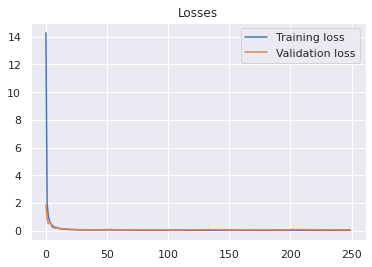

In [ ]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)


In [ ]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf7 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf7)
print('Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6+WF7): ', result_metrics)

Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6+WF7):  {'mae': 0.14536284, 'rmse': 0.19045454, 'mse': 0.03627293}


In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf7[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1+WF2+WF5+WF6+WF7)')
plt.show()

Text(0.5, 1.0, 'Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6+WF7) - 48h window')

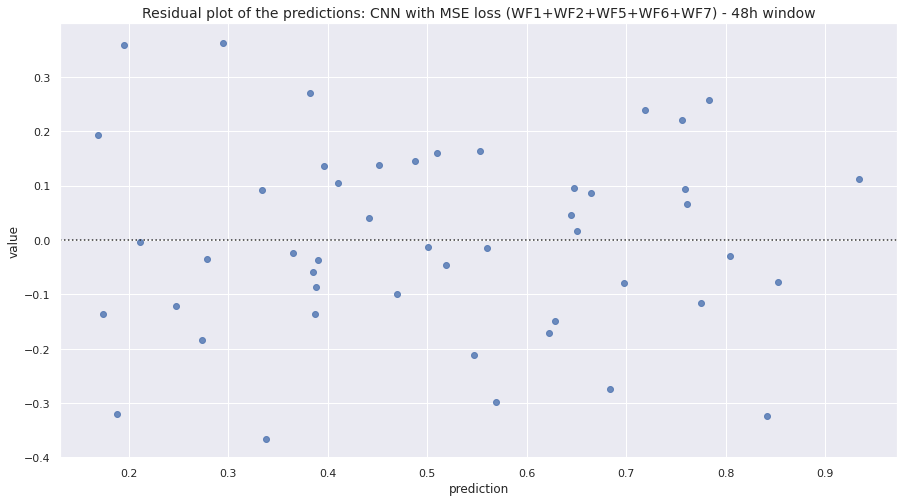

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf7[-96:-48]['prediction'], y=df_result_cnn_wf7[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6+WF7) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0222	 Validation loss: 0.0501
[2/50] Training loss: 0.0202	 Validation loss: 0.0496
[3/50] Training loss: 0.0196	 Validation loss: 0.0495
[4/50] Training loss: 0.0190	 Validation loss: 0.0494
[5/50] Training loss: 0.0184	 Validation loss: 0.0494
[6/50] Training loss: 0.0179	 Validation loss: 0.0493
[7/50] Training loss: 0.0176	 Validation loss: 0.0493
[8/50] Training loss: 0.0176	 Validation loss: 0.0491
[9/50] Training loss: 0.0170	 Validation loss: 0.0491
[10/50] Training loss: 0.0166	 Validation loss: 0.0492
[20/50] Training loss: 0.0143	 Validation loss: 0.0492
[30/50] Training loss: 0.0128	 Validation loss: 0.0496
[40/50] Training loss: 0.0112	 Validation loss: 0.0501
[50/50] Training loss: 0.0102	 Validation loss: 0.0508


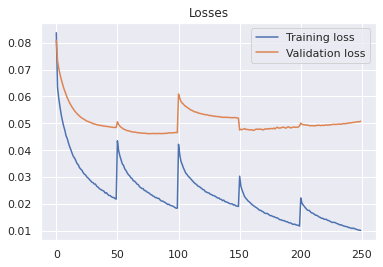

In [ ]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf7 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf7)
print('Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6+WF7): ', result_metrics)

In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf7[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7)')
plt.show()

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf7[-96:-48]['prediction'], y=df_result_rnn_wf7[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7) - 48h window',size=14)

# + WF4

In [ ]:
forecast_wf4_processed = pd.read_csv(path + 'wf4_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp4_unprocessed = train_wp4_unprocessed.tail(train_wp4_unprocessed.shape[0] -1)

forecast_wf4_processed.reset_index(drop=True, inplace=True)
train_wp4_unprocessed.reset_index(drop=True, inplace=True)
train_wf4_processed = pd.concat([forecast_wf4_processed, train_wp4_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf4 = generate_time_lags(train_wf4_processed, input_dim)

In [ ]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf4)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf4.columns, train_wf4)
  y_obs = train_wf4['wp4'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

Len of X 18656
Len of Y 18656
Target shape:  (10001, 1)
Training features 10001


In [ ]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6+WF7+WF4'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

In [ ]:
# CNN MSE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf4 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf4)
print('Result metrics for CNN with MAE loss (WF1+WF2+WF5+WF6+WF7+WF4): ', result_metrics)

In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_cnn_wf4[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4)')
plt.show()

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf4[-96:-48]['prediction'], y=df_result_cnn_wf4[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4) - 48h window',size=14)

## LSTM

[1/50] Training loss: 0.0218	 Validation loss: 0.0450
[2/50] Training loss: 0.0196	 Validation loss: 0.0445
[3/50] Training loss: 0.0184	 Validation loss: 0.0445
[4/50] Training loss: 0.0177	 Validation loss: 0.0438
[5/50] Training loss: 0.0170	 Validation loss: 0.0436
[6/50] Training loss: 0.0167	 Validation loss: 0.0436
[7/50] Training loss: 0.0161	 Validation loss: 0.0433
[8/50] Training loss: 0.0157	 Validation loss: 0.0435
[9/50] Training loss: 0.0155	 Validation loss: 0.0434
[10/50] Training loss: 0.0150	 Validation loss: 0.0431
[20/50] Training loss: 0.0129	 Validation loss: 0.0431
[30/50] Training loss: 0.0114	 Validation loss: 0.0434
[40/50] Training loss: 0.0100	 Validation loss: 0.0438
[50/50] Training loss: 0.0090	 Validation loss: 0.0440


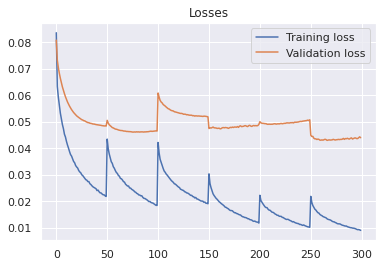

In [ ]:
# LSTM MSE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf4 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf4)
print('Result metrics for LSTM with MAE loss (WF1+WF2+WF5+WF6+WF7+WF4): ', result_metrics)

In [ ]:
#Plotting predictions
fig = plot_predictions(df_result_rnn_wf4[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4)')
plt.show()

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf4[-96:-48]['prediction'], y=df_result_rnn_wf4[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (WF1+WF2+WF5+WF6+WF7+WF4) - 48h window',size=14)

# + WF3

In [ ]:
forecast_wf3_processed = pd.read_csv(path + 'wf3_extracted_forecast_vals')

# drop first row as we do not have a forecast for it
train_wp3_unprocessed = train_wp3_unprocessed.tail(train_wp3_unprocessed.shape[0] -1)

forecast_wf3_processed.reset_index(drop=True, inplace=True)
train_wp3_unprocessed.reset_index(drop=True, inplace=True)
train_wf3_processed = pd.concat([forecast_wf3_processed, train_wp3_unprocessed], axis=1)

# generte timelags for WF3
input_dim = 100

train_wf3 = generate_time_lags(train_wf3_processed, input_dim)

In [ ]:
X_list = []
Y_list = []
Date_list = []

for i in range(len(train_wf3)):
  x_obs_list = []
  u_lag, v_lag, ws_lag, wd_lag, date_l = create_obs_per_row(i, train_wf3.columns, train_wf3)
  y_obs = train_wf3['wp3'].iloc[i]

  x_obs_list.append(u_lag)
  x_obs_list.append(v_lag)
  x_obs_list.append(ws_lag)
  x_obs_list.append(wd_lag)
  x_obs = np.array(x_obs_list)

  X_list.append(x_obs)
  Y_list.append(y_obs)
  Date_list.append(date_l)
  
print('Len of X',len(X_list))
print('Len of Y',len(Y_list))

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, date_test = train_val_test_split(X_list, Y_list, Date_list, 0.2)
X_train = np.array(X_train, dtype=np.float64)
X_val = np.array(X_val, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64 )
y_train = np.array(y_train, dtype=np.float64)
y_val = np.array(y_val, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


# Scale the data
scaler = get_scaler('minmax')

for i in range(len(X_train)):
  scaler.fit_transform(X_train[i])

for i in range(len(X_val)):
  scaler.fit_transform(X_val[i])

for i in range(len(X_test)):
  scaler.fit_transform(X_test[i])


y_train_arr = scaler.fit_transform(y_train.reshape(-1, 1))
print('Target shape: ',y_train_arr.shape)
y_val_arr = scaler.transform(y_val.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.reshape(-1, 1))

# Load the Data
X_train_arr = X_train.copy()
X_val_arr = X_val.copy()
X_test_arr = X_test.copy()

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

print('Training features',len(train_features))

In [ ]:
# train baseline model
training_session = 'WF1+WF2+WF5+WF6+WF7+WF4+WF3'
df_baseline = train_baseline_model(0.2, model_baseline, X_list, Y_list, date_test)
baseline_metrics = calculate_metrics_baseline(df_baseline)
print('Baseline Linear Regression result metrics for ' + training_session,baseline_metrics)

[1/50] Training loss: 0.0483	 Validation loss: 0.0564
[2/50] Training loss: 0.0359	 Validation loss: 0.0497
[3/50] Training loss: 0.0323	 Validation loss: 0.0497
[4/50] Training loss: 0.0306	 Validation loss: 0.0502
[5/50] Training loss: 0.0291	 Validation loss: 0.0502
[6/50] Training loss: 0.0283	 Validation loss: 0.0520
[7/50] Training loss: 0.0271	 Validation loss: 0.0511
[8/50] Training loss: 0.0266	 Validation loss: 0.0518
[9/50] Training loss: 0.0259	 Validation loss: 0.0530
[10/50] Training loss: 0.0257	 Validation loss: 0.0524
[20/50] Training loss: 0.0195	 Validation loss: 0.0579
[30/50] Training loss: 0.0171	 Validation loss: 0.0603
[40/50] Training loss: 0.0142	 Validation loss: 0.0639
[50/50] Training loss: 0.0140	 Validation loss: 0.0694


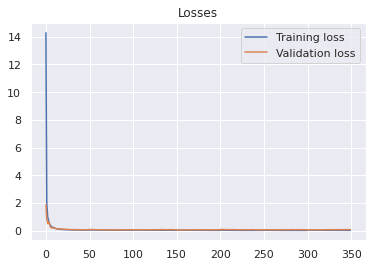

In [ ]:
# CNN MAE train

opt_cnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_cnn.plot_losses()

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

# Result Metrics after training with All Wind Farms (WFs)
 ### - Model: CNN with MSE loss


In [ ]:
# Result metrics: 

predictions, values = opt_cnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_cnn_wf3 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_cnn_wf3)
print('Result metrics for CNN with MSE loss (): ', result_metrics)

In [ ]:
#Plotting predictions
plot_predictions(df_result_cnn_wf3[-96:-48], df_baseline[-96:-48],'CNN with MSE loss (all wind farms)')

plt.show()

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_cnn_wf3[-96:-48]['prediction'], y=df_result_cnn_wf3[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: CNN with MSE loss (all wind farms) - 48h window',size=14)

## LSTM

In [ ]:
# LSTM MAE train

opt_rnn.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt_rnn.plot_losses()

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# Result metrics: 

predictions, values = opt_rnn.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

preds = np.array(predictions).flatten()
vals = np.array(values).flatten()
df_result_rnn_wf3 = format_predictions(preds , vals, y_test, scaler)
result_metrics = calculate_metrics(df_result_rnn_wf3)
print('Result metrics for LSTM with MSE loss (all wind farms): ', result_metrics)

In [ ]:
#Plotting predictions
plot_predictions(df_result_rnn_wf3[-96:-48], df_baseline[-96:-48],'LSTM with MSE loss (all wind farms)')

plt.show()

In [ ]:
#Residuals
plt.figure(figsize=(15,8))
ax = sns.residplot(x=df_result_rnn_wf3[-96:-48]['prediction'], y=df_result_rnn_wf3[-96:-48]['value'])
ax.set_title('Residual plot of the predictions: LSTM with MSE loss (all wind farms) - 48h window',size=14)